In [260]:
%matplotlib inline

import argparse
from collections import defaultdict, OrderedDict
import multiprocessing as mp
import os
import pickle
import re
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

from joblib import Parallel, delayed
import numpy as np
# import ray
# # use fewer CPUs so the OS doesn't run out of processes
# ray.init(num_cpus=16)
# import modin.pandas as pd
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

log = sys.stdout

## Global, general purpose functions

In [261]:
def pickle_dump(obj, path):
    with open(path, "wb") as outfile:
        pickle.dump(obj, outfile)
        
        
def pickle_load(path):
    with open(path, "rb") as infile:
        return pickle.load(infile)
    
def nan_fraction(df, verbose=False, show_plots=False):
    ostream = sys.stdout if verbose else open(os.devnull, "w")
    column_wise =  df.isna().mean()
    in_total = df.isna().sum().sum() / df.size
    print("Per column:\n", column_wise, file=ostream)
    if show_plots:
        plt.title("Fraction of NaNs in column")
        sns.distplot(column_wise.values)
    print("In total: ", in_total, file=ostream)
    return column_wise, in_total

## Loading data

### Setting up paths

In [262]:
root_data_dir = subprocess.check_output(
    "echo $MB_PROCESSED/vcf_to_ase/", 
    shell=True
).decode("UTF-8").strip()
sample_data_dir = "/".join([root_data_dir, "first_sample", "scRNA"])

cluster_label_col = "seurat_clusters"#"cl_hierarchical"
barcode_col = "barcode"

### Loading reference genome

In [263]:
genome_df = pd.read_csv(f"{root_data_dir}/genome.csv")
assert np.all(np.isin(["CHROM", "START", "END", "GENE_ID"], genome_df.columns))
genome_df.head()

,CHROM,START,END,GENE_NAME,GENE_ID
0,1,11869,14412,DDX11L1,ENSG00000223972
1,1,14363,29806,WASH7P,ENSG00000227232
2,1,29554,31109,MIR1302-10,ENSG00000243485
3,1,34554,36081,FAM138A,ENSG00000237613
4,1,52473,54936,OR4G4P,ENSG00000268020


### Loading phasing information

In [264]:
phasing_df = pd.read_csv(f"{root_data_dir}/phasing.csv")
assert np.all(np.isin(["CHROM", "POS", "PHASE"], phasing_df.columns))
phasing_df.head()

,CHROM,POS,REF,ALT,PHASE
0,1,14464,A,T,1
1,1,14907,A,G,1
2,1,14976,G,A,1
3,1,15118,A,G,1
4,1,15211,T,G,1


### Loading read counts

In [265]:
def extract_barcodes(df):
    barcode_list = []
    barcode_pattern = r"(^(A|C|G|T)+-1)|(.*_(ad|dp)$)"
    for colname in df.columns:
        if re.match(barcode_pattern, colname) is not None:
            barcode_list.append(colname.split("_")[0])
    return np.unique(barcode_list)


def extract_snps(df):
    return np.array([
        f"{chrom},{pos}"
        for chrom, pos in 
        tqdm_notebook(df[["CHROM", "POS"]]\
                      .to_dense()\
                      .values\
                      .astype(np.int64), 
                      desc="extracting snps...")
    ])


def extract_counts(df, suffix="dp"):
    barcode_list = extract_barcodes(df)
    return df[[f"{barcode}_{suffix}" for barcode in barcode_list]]

In [266]:
%%time
if os.path.exists(f"{sample_data_dir}/raw_counts.pkl"):
    # this is much faster than reading in chunks and concatenating those
    raw_counts_df = pd.read_pickle(f"{sample_data_dir}/raw_counts.pkl")
else:
    chunksize = 2**14
    reader = pd.read_csv(f"{sample_data_dir}/raw_counts.csv", 
                         dtype=np.float64, 
                         chunksize=chunksize)
    raw_counts_df = pd.concat([chunk.to_sparse() for chunk in 
                        tqdm_notebook(
                            reader, 
                            desc=f"reading counts in chunks of size {chunksize}")
                       ])
raw_counts_df.head()

CPU times: user 32min 41s, sys: 15min 27s, total: 48min 8s
Wall time: 36min 2s


,CHROM,POS,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCGATG-1_ad,AAACCTGGTAGCGATG-1_dp,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
0,1.0,14907.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,14976.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,15118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,15211.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,16068.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [267]:
raw_counts_df.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 240960 entries, 0 to 240959
Columns: 13340 entries, CHROM to TTTGTCATCCCAAGAT-1_dp
dtypes: Sparse[float64, nan](13340)
memory usage: 24.2 MB


Per column:
 CHROM                    0.000000
POS                      0.000000
AAACCTGCACATCCAA-1_ad    0.999797
AAACCTGCACATCCAA-1_dp    0.999797
AAACCTGCACTAGTAC-1_ad    0.999680
                           ...   
TTTGTCAGTTAAAGAC-1_dp    0.999689
TTTGTCATCATCGGAT-1_ad    0.999427
TTTGTCATCATCGGAT-1_dp    0.999427
TTTGTCATCCCAAGAT-1_ad    0.999660
TTTGTCATCCCAAGAT-1_dp    0.999660
Length: 13340, dtype: float64
In total:  0.9993720924647238


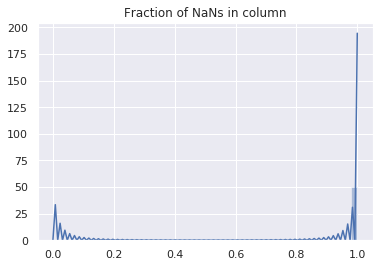

In [268]:
nan_fraction(raw_counts_df, verbose=True, show_plots=True);

In [269]:
nan_fraction(raw_counts_df)

(CHROM                    0.000000
 POS                      0.000000
 AAACCTGCACATCCAA-1_ad    0.999797
 AAACCTGCACATCCAA-1_dp    0.999797
 AAACCTGCACTAGTAC-1_ad    0.999680
                            ...   
 TTTGTCAGTTAAAGAC-1_dp    0.999689
 TTTGTCATCATCGGAT-1_ad    0.999427
 TTTGTCATCATCGGAT-1_dp    0.999427
 TTTGTCATCCCAAGAT-1_ad    0.999660
 TTTGTCATCCCAAGAT-1_dp    0.999660
 Length: 13340, dtype: float64, 0.9993720924647238)

### Loading clustering information

In [270]:
def extract_clusters(clustering_df, entry_col="BARCODE"):
    cluster_to_entries = {}
    for label, indices in clustering_df.groupby("LABEL").groups.items():
        cluster_to_entries[label] = clustering_df[entry_col][indices].values
    return cluster_to_entries

def extract_cluster_labels(clustering_df):
    return sorted(clustering_df.LABEL.unique())

In [287]:
clustering_df = pd.read_csv(f"{sample_data_dir}/clustering.tsv", '\t')
clustering_df.rename(columns={cluster_label_col : "LABEL", 
                              barcode_col : "BARCODE"}, inplace=True)

assert np.all(clustering_df["BARCODE"].isin(extract_barcodes(raw_counts_df)))

print("Cluster labels: ", extract_cluster_labels(clustering_df))

clustering_df.head()

Cluster labels:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


,BARCODE,LABEL,tSNE_1,tSNE_2
0,AAACCTGCACATCCAA-1,1,-12.448108,27.412456
1,AAACCTGCACTAGTAC-1,0,9.738823,11.845293
2,AAACCTGCATCATCCC-1,2,7.208576,-9.511222
3,AAACCTGGTAGCTCCG-1,1,-20.766361,18.106085
4,AAACCTGGTCTAAACC-1,2,5.619219,-12.530333


## Ensuring that alternative allele is maternal (0|1 in raw phasing results)

In [293]:
%%time
phasing_df = phasing_df.merge(raw_counts_df[["CHROM", "POS"]].to_dense())
assert phasing_df.shape[0] == raw_counts_df.shape[0]

if os.path.exists(f"{sample_data_dir}/counts.pkl"):
    counts_df = pd.read_pickle(f"{sample_data_dir}/counts.pkl")
else:
    counts_df = raw_counts_df.copy()
    counts_df["PHASE"] = phasing_df.PHASE
    male_alt = counts_df.PHASE == 1
    
    for barcode in tqdm_notebook(extract_barcodes(counts_df), desc="cell_barcode"):
        ad = counts_df[f"{barcode}_ad"].to_dense()
        dp = counts_df[f"{barcode}_dp"].to_dense()
        ad[male_alt] = dp[male_alt].sub(ad[male_alt], fill_value=0)
        counts_df[f"{barcode}_ad"] = ad.to_sparse()
        
    assert nan_fraction(counts_df.drop(columns=["PHASE"]))[1] == nan_fraction(raw_counts_df)[1]
    counts_df.to_pickle(f"{sample_data_dir}/counts.pkl")

CPU times: user 6min 51s, sys: 1min 19s, total: 8min 10s
Wall time: 8min 29s


In [294]:
# ensure that non-phased SNPs were filtered out
assert np.all(np.isin(extract_snps(counts_df), 
                      extract_snps(phasing_df)))

## Mapping SNPs to genes (and the other way around)

In [292]:
counts_df = pd.read_pickle(f"{sample_data_dir}/counts.pkl")
genome_df = pd.read_csv(f"{root_data_dir}/genome.csv")
snp_df = counts_df[["CHROM", "POS"]].to_dense().astype(np.int64)

FileNotFoundError: [Errno 2] No such file or directory: '/icgc/dkfzlsdf/analysis/B260/users/v390v/medulloblastoma/data/processed/vcf_to_ase//first_sample/scRNA/counts.pkl'

In [ ]:
def extract_genes_on_chromosome(df):
    chrom_to_genes = {}
    for chrom in genome_df["CHROM"].value_counts().keys():
        chrom_to_genes[chrom] = genome_df[genome_df.CHROM == chrom]
    return chrom_to_genes

chrom_to_genes = extract_genes_on_chromosome(genome_df)

In [ ]:
%%time

# Here gene coverage for each phased SNP is computed
# TODO: rewrite this using "bedtools intersect".
# This part doesn't scale well.

def map_snp_to_genes(snp_tuple):
    chrom, pos = snp_tuple
    # 1-based to 0-based 
    pos -= 1 # because CellCNP is 1-based, but .bed files are 0-based
    genes_on_chrom = chrom_to_genes[str(chrom)]
    mask = (genes_on_chrom.START <= pos) & (pos < genes_on_chrom.END)
    return ';'.join(genes_on_chrom[mask].GENE_ID)

pool = mp.Pool(16)
result = pool.map(map_snp_to_genes, 
                  tqdm_notebook(snp_df.values))
pool.close()
pool.join()

In [ ]:
""" Here the raw results computed in parallel are parsed """

snp_to_genes, gene_to_snps = {}, OrderedDict()

# This way we ensure proper gene ordering
for gene_id in genome_df.GENE_ID:
    gene_to_snps[gene_id] = []

for i, row in tqdm_notebook(enumerate(snp_df.values), "mapping SNPs to genes"):
    chrom, pos = row
    snp = f"{chrom},{pos}"
    snp_to_genes[snp] = result[i].split(";") if result[i] else []
    for gene in snp_to_genes[snp]:
        gene_to_snps[gene].append(snp)

In [ ]:
plt.figure(figsize=(16,8))
sns.set(font_scale=1.5)
plt.title("Number of genes covering one SNP")
sns.distplot([len(gene_list) for gene_list in snp_to_genes.values()]);

In [ ]:
plt.figure(figsize=(16,8))
plt.title("Number of SNPs covered by gene")
sns.distplot([len(snp_list) for snp_list in gene_to_snps.values()]);

In [ ]:
pickle_dump(snp_to_genes, f"{sample_data_dir}/snp_to_genes.pkl")
pickle_dump(gene_to_snps, f"{sample_data_dir}/gene_to_snps.pkl")

## Aggregating read counts over genes

In [295]:
gene_to_snps = pickle_load(f"{sample_data_dir}/gene_to_snps.pkl")
snp_to_genes = pickle_load(f"{sample_data_dir}/snp_to_genes.pkl")
gene_counts_df = pd.SparseDataFrame()

In [296]:
snp_to_idx = {snp : i for i, snp in 
              tqdm_notebook(enumerate(extract_snps(counts_df)), 
                            "processing snps...")}

Per column:
 AAACCTGCACATCCAA-1_ad    0.999797
AAACCTGCACATCCAA-1_dp    0.999797
AAACCTGCACTAGTAC-1_ad    0.999680
AAACCTGCACTAGTAC-1_dp    0.999680
AAACCTGCATCATCCC-1_ad    0.999830
                           ...   
TTTGTCAGTTAAAGAC-1_dp    0.999689
TTTGTCATCATCGGAT-1_ad    0.999427
TTTGTCATCATCGGAT-1_dp    0.999427
TTTGTCATCCCAAGAT-1_ad    0.999660
TTTGTCATCCCAAGAT-1_dp    0.999660
Length: 13338, dtype: float64
In total:  0.9995219458299157


(AAACCTGCACATCCAA-1_ad    0.999797
 AAACCTGCACATCCAA-1_dp    0.999797
 AAACCTGCACTAGTAC-1_ad    0.999680
 AAACCTGCACTAGTAC-1_dp    0.999680
 AAACCTGCATCATCCC-1_ad    0.999830
                            ...   
 TTTGTCAGTTAAAGAC-1_dp    0.999689
 TTTGTCATCATCGGAT-1_ad    0.999427
 TTTGTCATCATCGGAT-1_dp    0.999427
 TTTGTCATCCCAAGAT-1_ad    0.999660
 TTTGTCATCCCAAGAT-1_dp    0.999660
 Length: 13338, dtype: float64, 0.9995219458299157)

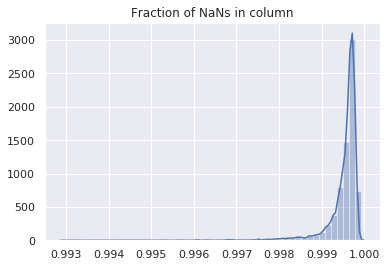

In [297]:
nan_fraction(counts_df.drop(columns=["CHROM", "POS", "PHASE"]), 
             verbose=True, show_plots=True)

In [298]:
%%time

gene_to_snp_ids = {gene : np.array([snp_to_idx[snp] for snp in snp_list]) 
                   for gene, snp_list in tqdm_notebook(gene_to_snps.items(), 
                                                       desc="mapping refinement")}

def extract_gene_counts(barcode):
    gene_to_ad, gene_to_dp = [], []
    # I need to convert these columns to dense format
    # because I need only a subset of rows on each iteration 
    ad = counts_df[f"{barcode}_ad"].to_dense().values
    dp = counts_df[f"{barcode}_dp"].to_dense().values
    # gene_to_snps is an OrderedDict, so we can guarantee
    # that all the genes are processed in a correct order
    for gene, snp_ids in gene_to_snp_ids.items():
        if len(snp_ids) > 0:
            ad_sample, dp_sample = ad[snp_ids], dp[snp_ids]
            gene_to_ad.append(np.nan if np.all(np.isnan(ad_sample)) else np.nansum(ad_sample))
            gene_to_dp.append(np.nan if np.all(np.isnan(dp_sample)) else np.nansum(dp_sample))
    return pd.DataFrame({f"{barcode}_ad" : gene_to_ad, 
                         f"{barcode}_dp" : gene_to_dp})

with mp.Pool(16) as pool:
    result_list = pool.map(
        extract_gene_counts, 
        tqdm_notebook(extract_barcodes(counts_df), 
                      desc="cell_barcode processing")
    )
# result_list = [extract_gene_counts(barcode) for barcode in tqdm_notebook(extract_barcodes(counts_df))]    
gene_counts_df = pd.concat(result_list, axis=1).to_dense()

CPU times: user 3.22 s, sys: 26.3 s, total: 29.5 s
Wall time: 2min 46s


In [299]:
snps_intersecting_genes = []
for gene, snp_list in gene_to_snps.items():
    snps_intersecting_genes += snp_list
snps_intersecting_genes = np.unique(snps_intersecting_genes)
snps_intersecting_genes.size / counts_df.shape[0]

0.7138363213811421

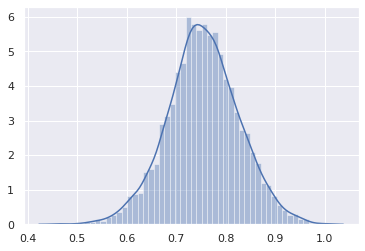

In [300]:
fractions = []
counts = []
indices = np.array([snp_to_idx[snp] for snp in snps_intersecting_genes])
for barcode in tqdm_notebook(extract_barcodes(counts_df)):
    dp_col = counts_df[f"{barcode}_dp"].to_dense().values
    counts.append((~np.isnan(dp_col[indices])).sum())
    fractions.append(counts[-1] / (~np.isnan(dp_col)).sum())
sns.distplot(fractions)

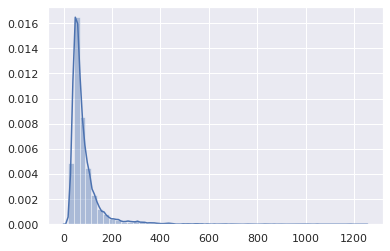

In [301]:
sns.distplot(counts)

In [302]:
gene_counts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14706 entries, 0 to 14705
Columns: 13338 entries, AAACCTGCACATCCAA-1_ad to TTTGTCATCCCAAGAT-1_dp
dtypes: float64(13338)
memory usage: 1.5 GB


Per column:
 AAACCTGCACATCCAA-1_ad    0.997620
AAACCTGCACATCCAA-1_dp    0.997620
AAACCTGCACTAGTAC-1_ad    0.996804
AAACCTGCACTAGTAC-1_dp    0.996804
AAACCTGCATCATCCC-1_ad    0.998164
                           ...   
TTTGTCAGTTAAAGAC-1_dp    0.996600
TTTGTCATCATCGGAT-1_ad    0.992860
TTTGTCATCATCGGAT-1_dp    0.992860
TTTGTCATCCCAAGAT-1_ad    0.995852
TTTGTCATCCCAAGAT-1_dp    0.995852
Length: 13338, dtype: float64
In total:  0.9949163345664594


(AAACCTGCACATCCAA-1_ad    0.997620
 AAACCTGCACATCCAA-1_dp    0.997620
 AAACCTGCACTAGTAC-1_ad    0.996804
 AAACCTGCACTAGTAC-1_dp    0.996804
 AAACCTGCATCATCCC-1_ad    0.998164
                            ...   
 TTTGTCAGTTAAAGAC-1_dp    0.996600
 TTTGTCATCATCGGAT-1_ad    0.992860
 TTTGTCATCATCGGAT-1_dp    0.992860
 TTTGTCATCCCAAGAT-1_ad    0.995852
 TTTGTCATCCCAAGAT-1_dp    0.995852
 Length: 13338, dtype: float64, 0.9949163345664594)

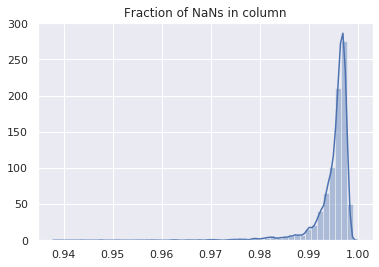

In [303]:
nan_fraction(gene_counts_df, verbose=True, show_plots=True)

In [304]:
cdf_csum, gdf_csum = 0, 0
for barcode in tqdm_notebook(extract_barcodes(counts_df)):
    cdf_csum += (~counts_df[f"{barcode}_dp"].isna()).sum()
    gdf_csum += (~gene_counts_df[f"{barcode}_dp"].isna()).sum()
print(100 * gdf_csum / cdf_csum)

64.90071138938968


In [305]:
gene_counts_df.insert(0, "GENE_ID", [gene for gene, snp_list 
                                     in gene_to_snps.items() 
                                     if len(snp_list) > 0])

In [306]:
gene_counts_df.head()

,GENE_ID,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCGATG-1_ad,AAACCTGGTAGCGATG-1_dp,AAACCTGGTAGCTCCG-1_ad,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
0,ENSG00000227232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000238009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000239906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ENSG00000228463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSG00000230021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [307]:
true_gene_ids = np.hstack(np.where(genome_df.GENE_ID == gene_id) 
                          for gene_id in tqdm_notebook(gene_counts_df.GENE_ID))

In [308]:
# assert correct (strictly ascending) gene ordering in gene_counts_df
assert np.all(np.diff(true_gene_ids) > 0) 

In [309]:
gene_counts_df.to_pickle(f"{sample_data_dir}/gene_counts.pkl")

## Summarizing the dataset (for QC purposes)

In [310]:
def describe_raw_counts(counts_df, desc, clustering_df=None, feature_name="SNP"):
    """
    @counts_df — pd.SparseDataframe — raw counts
    @desc — description of counts_df
    @clustering_df — pd.DataFrame — assigns cluster label to each barcode
    
    This function summarizes the information about the raw counts.
    It computes such summary statistics as:
        1. Fraction of NaNs (per barcode)
        2. Average number of reads mapped to SNP (per barcode)
        3. Total number of reads (per barcode)
        4. Number of SNPs with at least one mapped read (per barcode). 
    If clustering information is provided, it also computes the distribution
    of reads across genome, taking cluster structure into account. 
    To do so, it adds up the reads mapping to each SNP (individually) for each 
    barcode in the cluster and then divides the sum by the cluster size.
    """
    
    print("{} columns, {} barcodes, {} {}s".format(
        counts_df.shape[1],
        len(extract_barcodes(counts_df)),
        counts_df.shape[0],
        feature_name
    ))

    fig, axes = plt.subplots(2, 2, figsize=(10,10), constrained_layout=True)
    fig.suptitle(desc)
    axes[0,0].set_title("Fraction of NaNs per cell");
    counts_df.isna().mean().hist(ax=axes[0,0]);

    axes[0,1].set_title(f"Reads per {feature_name} (on average) per cell");
    extract_counts(counts_df, suffix="dp").mean().hist(ax=axes[0,1]);

    axes[1,0].set_title("Reads per barcode (in total)");
    extract_counts(counts_df, suffix="dp").sum().hist(ax=axes[1,0]);

    axes[1,1].set_title(f"{feature_name}s with at least one mapped read (one point per cell)");
    (extract_counts(counts_df, suffix="dp") > 0).sum().hist(ax=axes[1,1]);
    fig.show()

    if clustering_df is not None:
        cluster_to_barcodes = extract_clusters(clustering_df)
        cluster_label_list = extract_cluster_labels(clustering_df)
        print("Cluster labels: ", cluster_label_list)

        n_clusters = len(cluster_label_list)
        grid_shape = (n_clusters // 2 + n_clusters % 2, 2)
        sns.set()
        fig, axes = plt.subplots(*grid_shape, figsize=(15, 5 * n_clusters), constrained_layout=True)
        fig.suptitle("Distribution of reads in the genome (per cluster, DP counts averaged within cluster)")
        for i, label in enumerate(tqdm_notebook(cluster_label_list, desc="processing clusters")):
            ax = axes[i // grid_shape[1], i % grid_shape[1]]
            ax.set_title(f"Cluster label: {label}")
            ax.set_xlabel("SNP id")
            ax.set_ylabel("mean DP count")    
            dp_counts = np.zeros(counts_df.shape[0])
            for barcode in cluster_to_barcodes[label]:
                dp_counts = dp_counts + counts_df[f"{barcode}_dp"].to_dense().fillna(0).values
            dp_counts /= len(cluster_to_barcodes[label])
            ax.plot(dp_counts, label=label)
        fig.show()

13341 columns, 6669 barcodes, 240960 SNPs


/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Cluster labels:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


CPU times: user 2min 2s, sys: 4min 27s, total: 6min 29s
Wall time: 7min 54s


/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


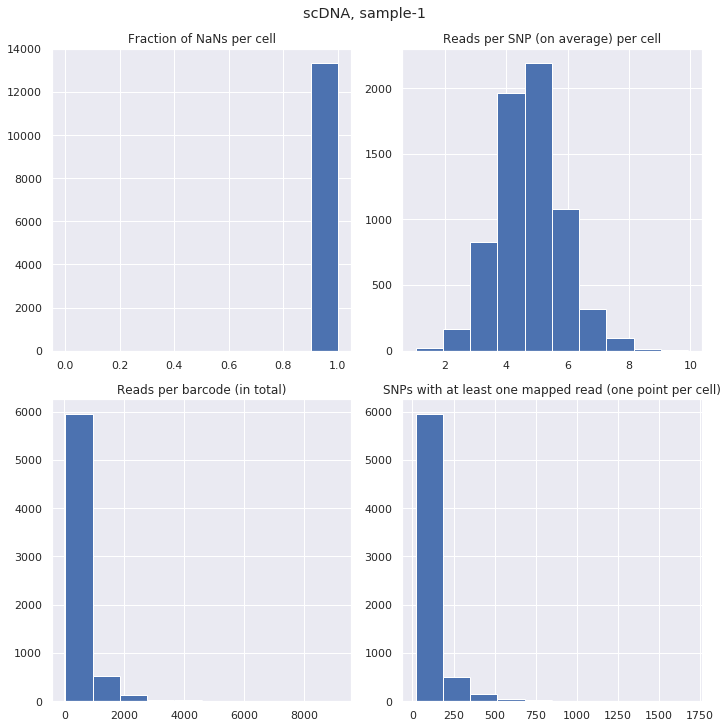

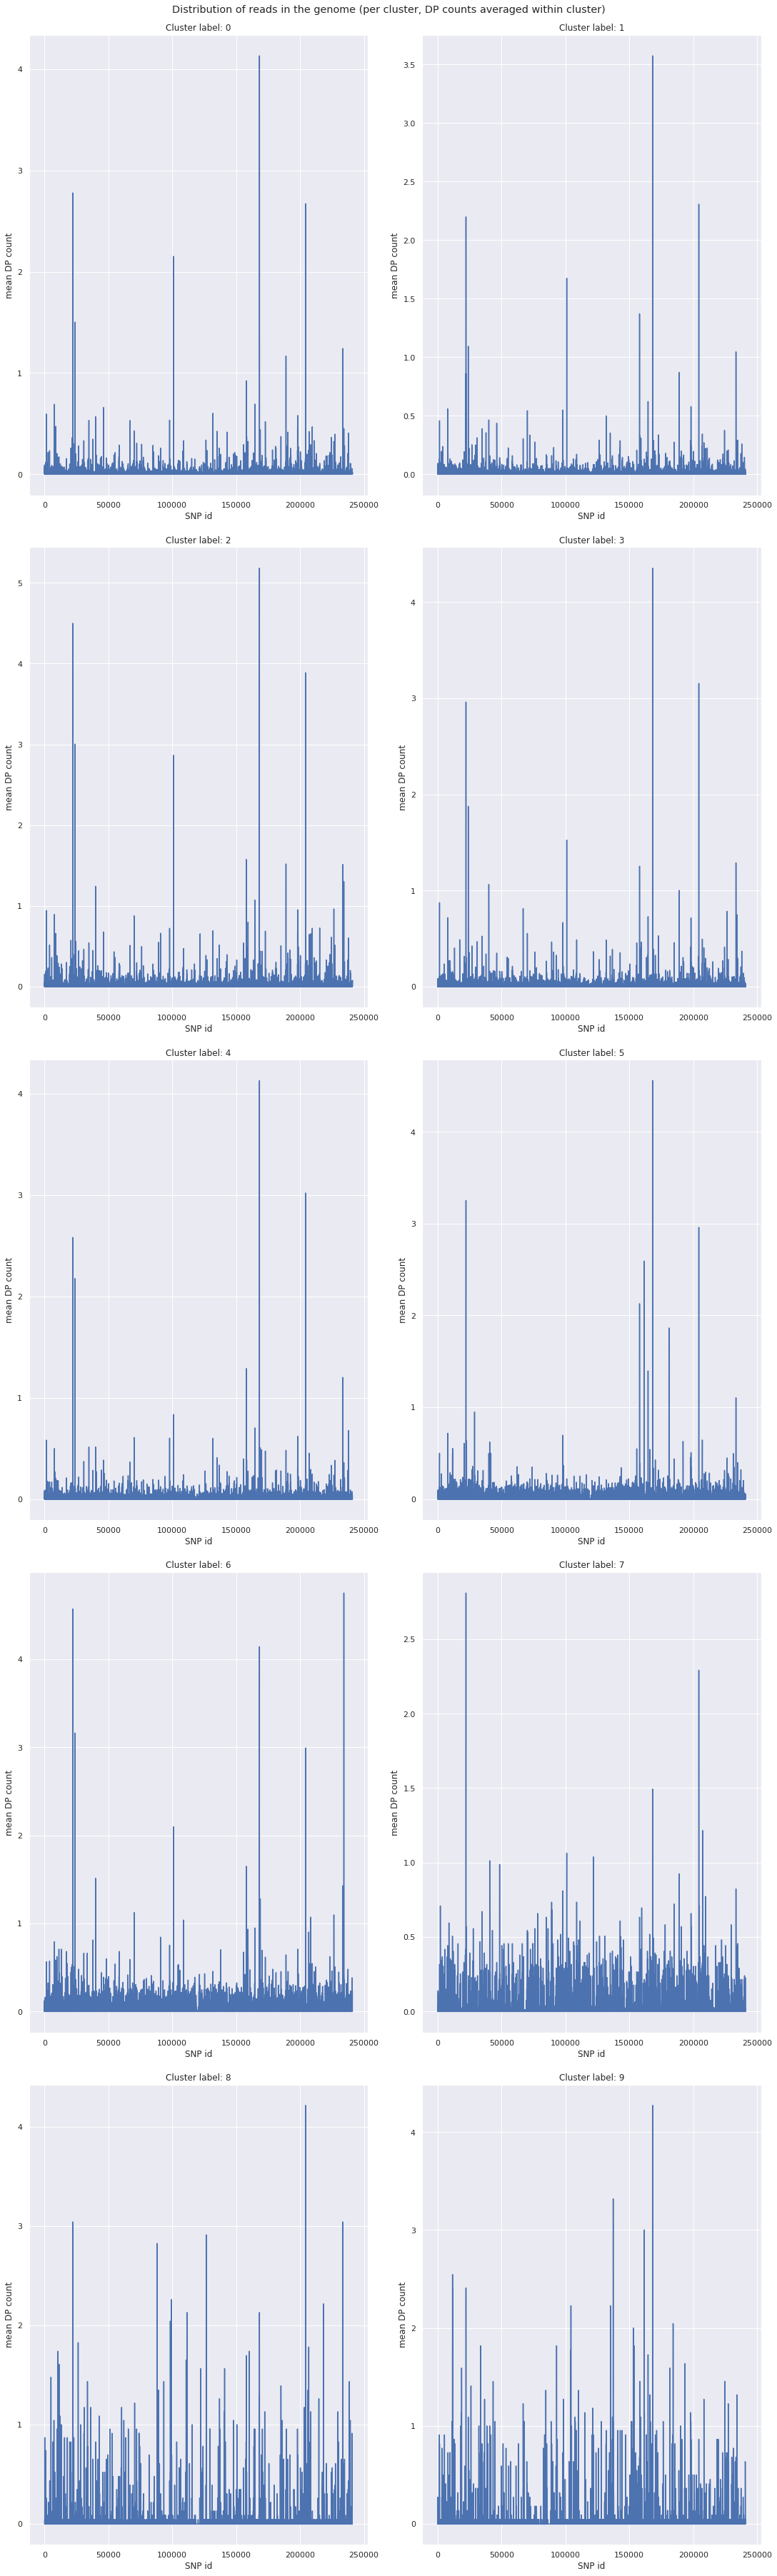

In [311]:
%%time
describe_raw_counts(counts_df, "scDNA, sample-1", clustering_df)

13339 columns, 6669 barcodes, 14706 genes


/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Cluster labels:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


CPU times: user 14.6 s, sys: 6.18 s, total: 20.8 s
Wall time: 22.1 s


/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


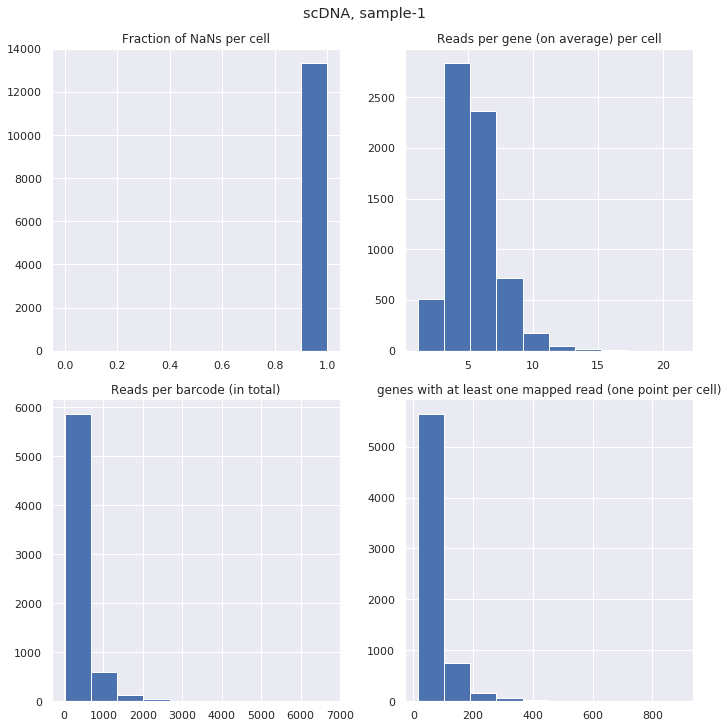

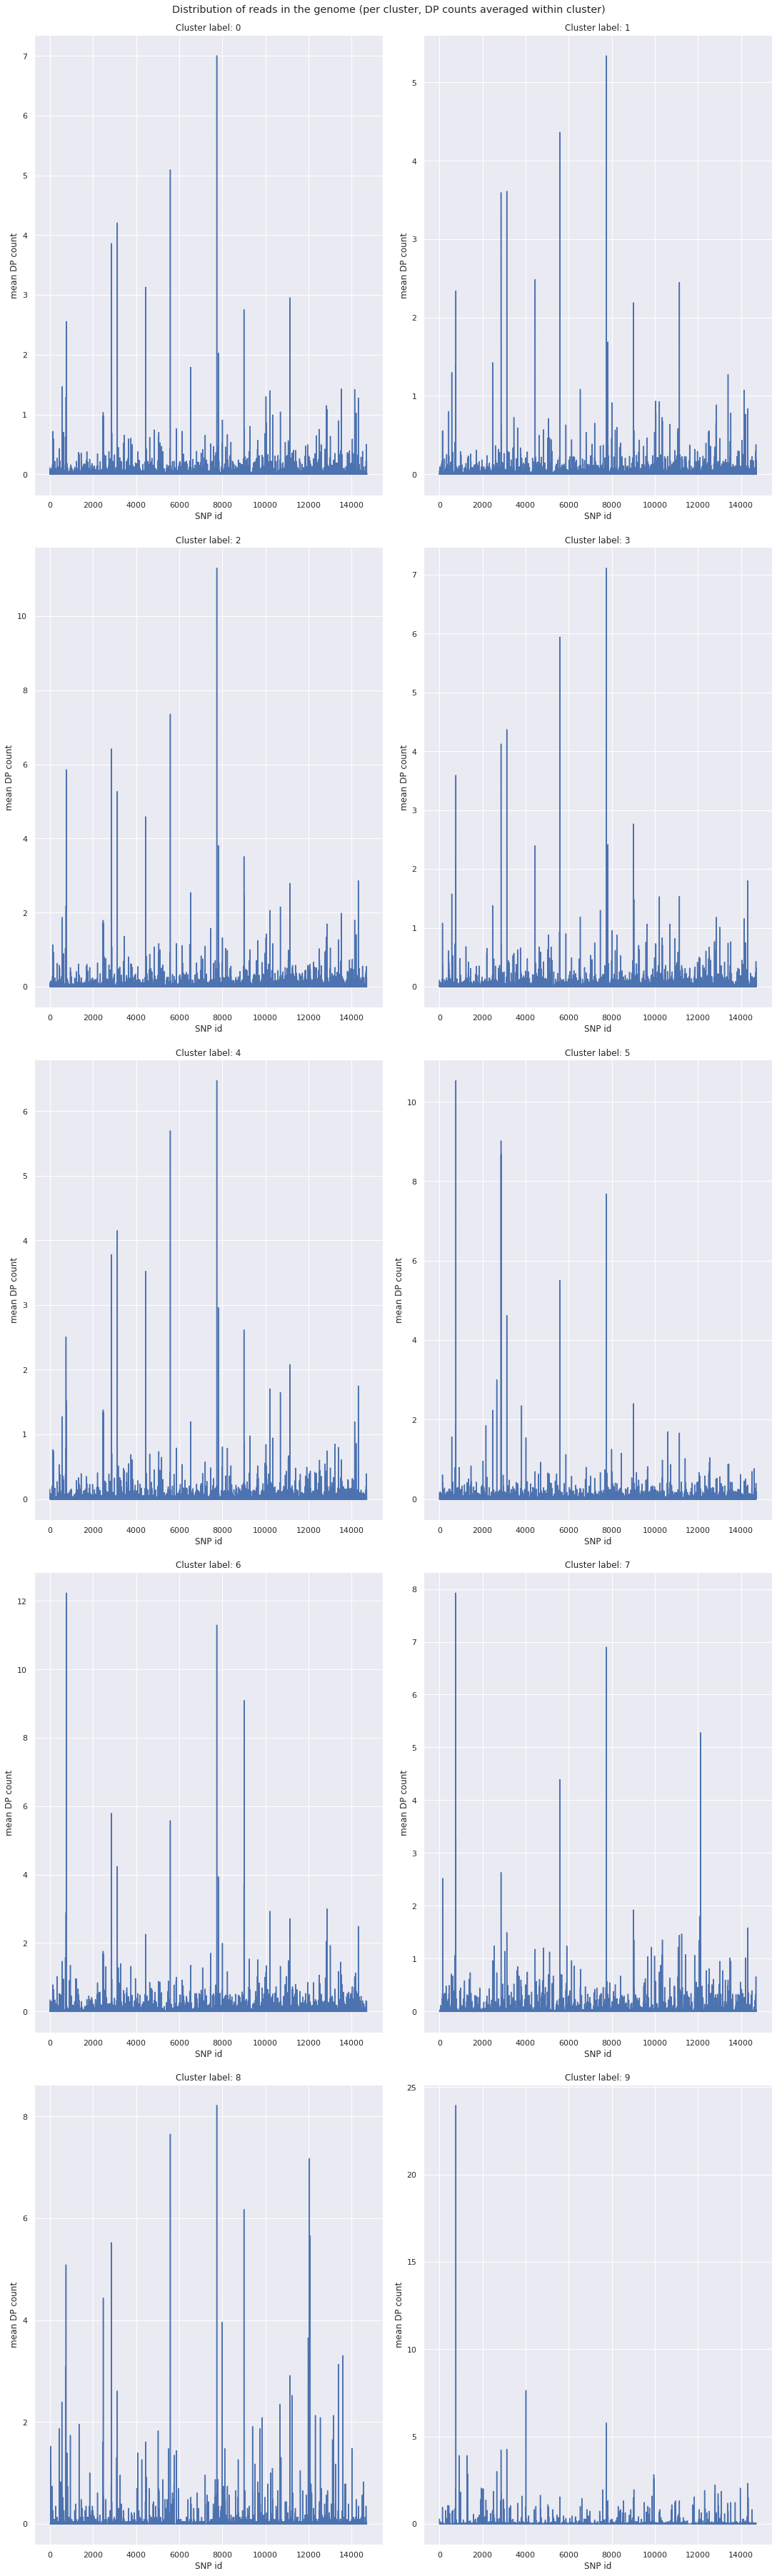

In [312]:
%%time
gene_counts_df = pd.read_pickle(f"{sample_data_dir}/gene_counts.pkl")
describe_raw_counts(gene_counts_df, "scDNA, sample-1", clustering_df, feature_name="gene")

## Getting an ASE matrix

In [313]:
def compute_ase(counts_df, barcode_list):
    ase_df = pd.concat([
        pd.DataFrame({
            f"{barcode}" 
            : counts_df[f"{barcode}_ad"].to_dense().fillna(0) 
            / counts_df[f"{barcode}_dp"].to_dense().fillna(0)
        }) 
        for barcode in tqdm_notebook(barcode_list, desc="barcode")], 
        axis=1
    )
    return ase_df

In [314]:
def plot_ase(ase_df, title="", figsize=(10,10)):
    try: 
        sns.clustermap(
            ase_df\
            .fillna(value=0.5)\
            .astype(np.float32)\
            .values,
            cmap="viridis",
            figsize=figsize
        ).fig.suptitle(title);
    except RecursionError:
        print("RecursionError: increase stack size")

In [315]:
%%time
gene_counts_df = pd.read_pickle(f"{sample_data_dir}/gene_counts.pkl")
ase_df = compute_ase(gene_counts_df, extract_barcodes(gene_counts_df))
ase_df["GENE_ID"] = gene_counts_df["GENE_ID"]
ase_df.to_pickle(f"{sample_data_dir}/ase.pkl")
ase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14706 entries, 0 to 14705
Columns: 6670 entries, AAACCTGCACATCCAA-1 to GENE_ID
dtypes: float64(6669), object(1)
memory usage: 748.4+ MB
CPU times: user 11 s, sys: 21.7 s, total: 32.7 s
Wall time: 41.6 s


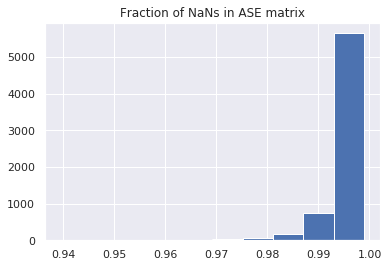

In [316]:
plt.title("Fraction of NaNs in ASE matrix")
ase_df.drop(columns="GENE_ID").isna().mean().hist()

## Aggregating by cell barcode (by groups of columns)

Take read counts and clustering info as an input.
Add up the counts in each cluster. 

In [317]:
def aggregate_by_barcode_groups(counts_df, clustering_df):
    assert np.all(np.isin(clustering_df.BARCODE, 
                          extract_barcodes(counts_df)))
    
    cluster_to_barcodes = extract_clusters(clustering_df)
    cluster_labels = extract_cluster_labels(clustering_df)
    
    result_df = pd.DataFrame()
    
    for label in tqdm_notebook(cluster_labels, desc="cluster label"):
        for suffix in ["ad", "dp"]:
            result_df[f"{label}_{suffix}"] = np.zeros(counts_df.shape[0])    
            na_mask = np.full(counts_df.shape[0], True)
            for barcode in cluster_to_barcodes[label]:
                counts = counts_df[f"{barcode}_{suffix}"].to_dense().values
                na_mask = na_mask & np.isnan(counts)
                result_df[f"{label}_{suffix}"] += np.nan_to_num(counts)
            result_df[f"{label}_{suffix}"][na_mask] = np.nan
    return result_df

In [318]:
gene_counts_df = pd.read_pickle(f"{sample_data_dir}/gene_counts.pkl")
clustered_df = aggregate_by_barcode_groups(gene_counts_df, clustering_df)
clustered_df.to_pickle(f"{sample_data_dir}/clustered_gene_counts.pkl")
clustered_df.head()

,0_ad,0_dp,1_ad,1_dp,2_ad,2_dp,3_ad,3_dp,4_ad,4_dp,5_ad,5_dp,6_ad,6_dp,7_ad,7_dp,8_ad,8_dp,9_ad,9_dp
0,164.0,183.0,41.0,61.0,77.0,107.0,59.0,88.0,88.0,102.0,20.0,39.0,52.0,52.0,NaN,NaN,NaN,NaN,0.0,6.0
1,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,1.0,0.0,4.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,3.0,5.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,3.0,6.0,1.0,2.0,2.0,7.0,1.0,1.0,0.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN


20 columns, 10 barcodes, 14706 SNPs


/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


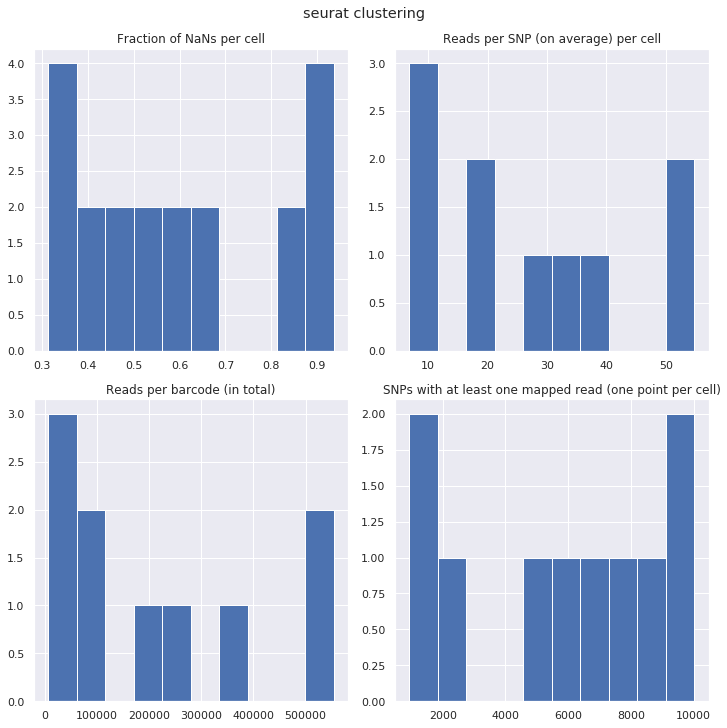

In [319]:
describe_raw_counts(clustered_df, "seurat clustering")

In [320]:
# clustered_ase_df = pd.read_pickle(f"{sample_data_dir}/clustered_ase_df.pkl")
clustered_ase_df = compute_ase(clustered_df, extract_cluster_labels(clustering_df))
clustered_ase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14706 entries, 0 to 14705
Data columns (total 10 columns):
0    10029 non-null float64
1    8654 non-null float64
2    10000 non-null float64
3    7866 non-null float64
4    7072 non-null float64
5    5496 non-null float64
6    4815 non-null float64
7    2681 non-null float64
8    1127 non-null float64
9    929 non-null float64
dtypes: float64(10)
memory usage: 1.1 MB


In [321]:
clustered_ase_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.896175,0.672131,0.719626,0.670455,0.862745,0.512821,1.0,NaN,NaN,0.0
1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.600000,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.000000,0.500000,0.500000,0.285714,1.000000,0.000000,0.5,NaN,NaN,NaN


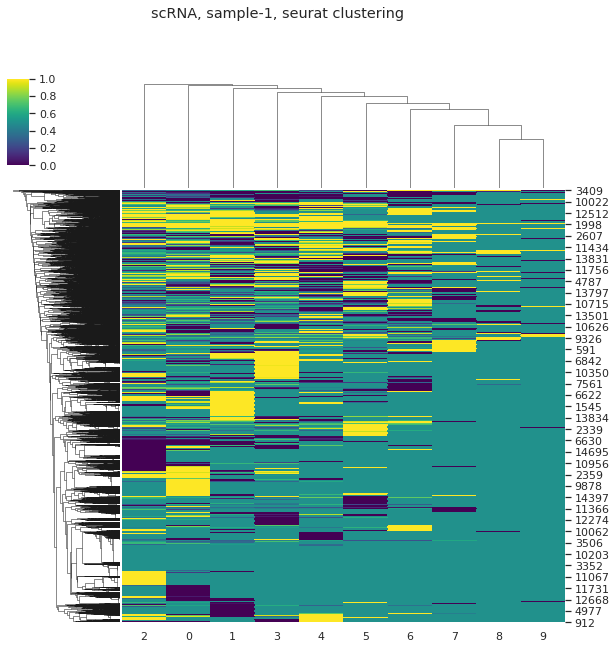

In [322]:
sys.setrecursionlimit(15000)
plot_ase(clustered_ase_df,
         "scRNA, sample-1, seurat clustering")

In [323]:
clustered_ase_df.to_pickle(f"{sample_data_dir}/clustered_ase_df.pkl")

## Aggregating by genes (by groups of rows)

This one is tricky because row operations seem to be very inefficient in pd.SparseDataFrame.  
But I still can process the barcode columns individually (or in batches). This is fast enough to be useful

In [324]:
def select_by_score(gene_counts_df, scoring_df, smaller_is_better=True, n_out=1000):
    assert np.all(np.isin(["SCORE", "GENE_ID"], scoring_df.columns))
    
    result_df = gene_counts_df.to_dense().merge(scoring_df[["SCORE", "GENE_ID"]])
    result_df.sort_values(by="SCORE", ascending=smaller_is_better, inplace=True)
    result_df = result_df.iloc[:n_out, :]
    result_df.sort_index(inplace=True)
    result_df.drop(columns=["SCORE"], inplace=True)
    return result_df

#### Giving it a try: selecting top 1000 genes by PCA loading scores

In [325]:
scoring_path = f"{root_data_dir}/first_sample/scores.tsv"
scoring_df = pd.read_csv(scoring_path)
scoring_df.head()

,Unnamed: 0,GENE_ID,1,2,3,SCORE
0,0,ENSG00000000003,1.0,1.0,2.0,0.001982
1,1,ENSG00000000005,1.0,1.0,2.0,0.001949
2,2,ENSG00000000419,2.0,2.0,4.0,0.004006
3,3,ENSG00000000457,2.0,2.0,4.0,0.004412
4,4,ENSG00000000460,2.0,2.0,4.0,0.004424


In [326]:
gene_counts_df = pd.read_pickle(f"{sample_data_dir}/gene_counts.pkl")
gene_counts_df.head()

,GENE_ID,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCGATG-1_ad,AAACCTGGTAGCGATG-1_dp,AAACCTGGTAGCTCCG-1_ad,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
0,ENSG00000227232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000238009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000239906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ENSG00000228463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSG00000230021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [327]:
%%time
top_1k_gene_counts_df = select_by_score(gene_counts_df, 
                                        scoring_df, 
                                        smaller_is_better=False, 
                                        n_out=1000)
top_1k_gene_counts_df.head()

CPU times: user 1.57 s, sys: 12.6 s, total: 14.2 s
Wall time: 17 s


,GENE_ID,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCGATG-1_ad,AAACCTGGTAGCGATG-1_dp,AAACCTGGTAGCTCCG-1_ad,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
145,ENSG00000219481,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,...,NaN,NaN,22.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN
710,ENSG00000230880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
711,ENSG00000203849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
720,ENSG00000178104,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
721,ENSG00000255148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [328]:
top_1k_clustered_gene_counts_df = aggregate_by_barcode_groups(
    top_1k_gene_counts_df, 
    clustering_df
)
top_1k_clustered_gene_counts_df.head()

,0_ad,0_dp,1_ad,1_dp,2_ad,2_dp,3_ad,3_dp,4_ad,4_dp,5_ad,5_dp,6_ad,6_dp,7_ad,7_dp,8_ad,8_dp,9_ad,9_dp
0,112.0,249.0,117.0,197.0,175.0,322.0,29.0,56.0,90.0,177.0,9.0,17.0,37.0,70.0,3.0,13.0,0.0,1.0,1.0,2.0
1,8.0,24.0,9.0,19.0,41.0,78.0,14.0,22.0,3.0,7.0,3.0,5.0,3.0,13.0,1.0,2.0,NaN,NaN,NaN,NaN
2,8.0,24.0,9.0,19.0,41.0,78.0,14.0,22.0,3.0,7.0,3.0,5.0,3.0,13.0,1.0,2.0,NaN,NaN,NaN,NaN
3,289.0,548.0,150.0,364.0,336.0,725.0,87.0,191.0,138.0,262.0,278.0,504.0,0.0,3.0,17.0,44.0,2.0,2.0,25.0,44.0
4,NaN,NaN,2.0,4.0,2.0,2.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [329]:
top_1k_ase_df = compute_ase(
    top_1k_clustered_gene_counts_df, 
    extract_cluster_labels(clustering_df)
)

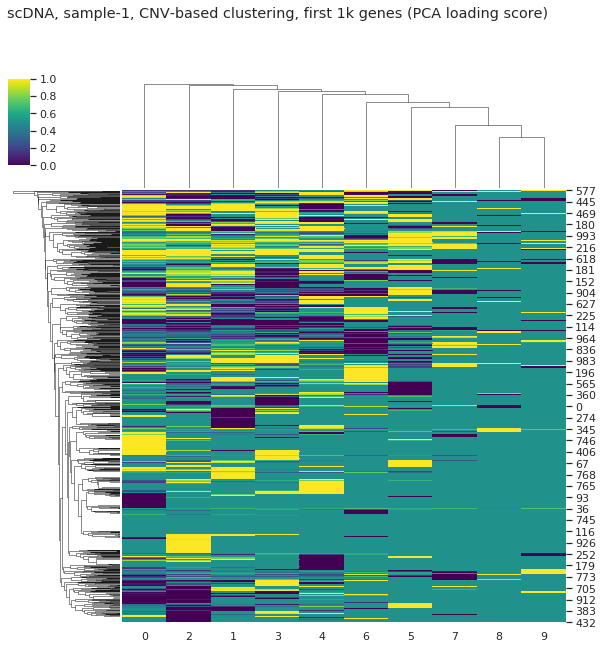

In [330]:
plot_ase(
    top_1k_ase_df,
    "scDNA, sample-1, CNV-based clustering, first 1k genes (PCA loading score)"
)

In [331]:
top_1k_gene_counts_df.to_pickle(f"{sample_data_dir}/top_1k_gene_counts.csv")

# HERE THE SECOND NOTEBOOK BEGINS

In [332]:
scDNA_dir = f"{root_data_dir}/first_sample/scDNA"
scRNA_dir = f"{root_data_dir}/first_sample/scRNA"

In [333]:
scRNA_counts_df = pd.read_pickle(f"{scRNA_dir}/gene_counts.pkl")
scDNA_counts_df = pd.read_pickle(f"{scDNA_dir}/gene_counts.pkl")

## Assigning labels via ASE profiles

In [334]:
scDNA_ase_df = pd.read_pickle(f"{scDNA_dir}/ase.pkl").to_dense()
scRNA_counts_df = pd.read_pickle(f"{scRNA_dir}/gene_counts.pkl").to_dense()

In [335]:
scDNA_ase_df.head()

,AAACCTGCACGACTAT-1,AAACCTGTCTTGCGAA-1,AAACGGGAGTGTTGAA-1,AAACGGGGTACTCACA-1,AAAGCAAAGCTGGTCC-1,AAAGCAAAGGCCATAG-1,AACACGTCACTGCGCA-1,AACACGTTCGATAGTC-1,AACCATGGTAAGTGTA-1,AACTCCCAGAGTAATC-1,...,TTCTCAAAGAAAGCTT-1,TTCTCCTCATCTCACC-1,TTCTCCTTCAAGCCAT-1,TTCTTAGAGTAGTGCG-1,TTGAACGCAGCGATGA-1,TTGCGTCCAACGGCTC-1,TTGGAACGTTCTGTCC-1,TTTATGCCATGTTTCT-1,TTTCCTCGTGATCCTA-1,GENE_ID
0,NaN,NaN,0.5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000227232
1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,ENSG00000268020
2,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,ENSG00000240361
3,1.0,0.0,0.0,NaN,0.0,0.6,1.0,0.333333,0.333333,0.666667,...,NaN,0.666667,1.0,0.0,0.5,0.0,1.000000,0.0,NaN,ENSG00000238009
4,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000239945


In [336]:
scRNA_counts_df.head()

,GENE_ID,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCGATG-1_ad,AAACCTGGTAGCGATG-1_dp,AAACCTGGTAGCTCCG-1_ad,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
0,ENSG00000227232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000238009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000239906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ENSG00000228463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSG00000230021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [339]:
cnv_tsv = f"{scDNA_dir}/scores.tsv"
scDNA_cnv_df = pd.read_csv(cnv_tsv, sep='\t')

In [340]:
scDNA_cnv_df.sort_values(by="loading_scores", ascending=False, inplace=True)

In [341]:
scDNA_cnv_df.head()

,gene_id,1,2,3,loading_scores
34507,ENSG00000236854,17.0,22.5,39.0,0.048392
30567,ENSG00000230964,9.0,9.5,17.0,0.017581
48353,ENSG00000261600,9.0,9.5,17.0,0.017581
8430,ENSG00000143429,9.0,9.5,17.0,0.017538
32589,ENSG00000233991,9.0,9.5,17.0,0.017466


In [ ]:
scDNA_ase_df

In [417]:
gene_ordering = {gene : i for i, gene in enumerate(scDNA_cnv_df.gene_id)}
scRNA_counts_df["GENE_RANK"] = [gene_ordering.get(gene) for gene in scRNA_counts_df.GENE_ID]
scDNA_ase_df["GENE_RANK"] = [gene_ordering.get(gene) for gene in scDNA_ase_df.GENE_ID]
scRNA_counts_df.head()

AttributeError: 'DataFrame' object has no attribute 'GENE_ID'

In [344]:
%%time
barcode_list = []
barcode_pattern = r"^(A|G|C|T)+-1_[ad|dp]"
for colname in tqdm_notebook(scRNA_counts_df.columns, 
                             desc="cell barcode"):
    if re.match(barcode_pattern, colname) is not None:
        barcode_list.append(colname.split("_")[0])
barcode_list = np.unique(barcode_list)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 169 ms


In [345]:
scDNA_ase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23037 entries, 0 to 23036
Columns: 406 entries, AAACCTGCACGACTAT-1 to GENE_RANK
dtypes: Sparse[object, nan](1), float64(405)
memory usage: 71.4 MB


In [394]:
scDNA_genes = scDNA_ase_df.GENE_ID
scRNA_genes = scRNA_counts_df.GENE_ID
common_genes = set(scDNA_genes) & set(scRNA_genes)
scDNA_ase_df = scDNA_ase_df[scDNA_ase_df.GENE_ID.isin(common_genes)]
scRNA_counts_df = scRNA_counts_df[scRNA_counts_df.GENE_ID.isin(common_genes)]

In [349]:
scDNA_ase_df.shape

(14702, 406)

In [350]:
scRNA_counts_df.shape

(14702, 13340)

In [351]:
scDNA_ase_df = scDNA_ase_df.sort_values(by="GENE_RANK", ascending=False).iloc[:1000, :]
scDNA_ase_df.sort_index(inplace=True)
scRNA_counts_df = scRNA_counts_df.sort_values(by="GENE_RANK", ascending=False).iloc[:1000, :]
scRNA_counts_df.sort_index(inplace=True)

<Figure size 1440x2160 with 0 Axes>

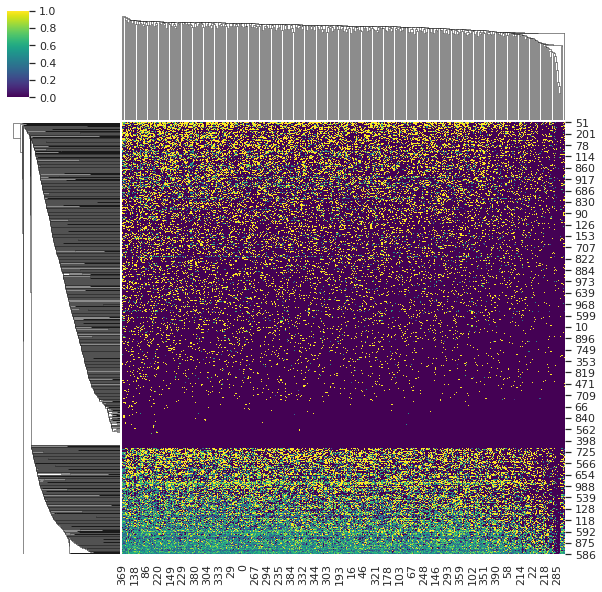

In [353]:
plt.figure(figsize=(20,30))
sns.clustermap(
    scDNA_ase_df\
    .drop(columns=["GENE_ID", "GENE_RANK"])\
    .fillna(value=0)\
    .astype(np.float32)\
    .values,
    cmap="viridis"
);

In [399]:
scDNA_ase_df.drop(columns=["GENE_ID"], inplace=True)
# scRNA_counts_df.drop(columns=["GENE_RANK"], inplace=True)

/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [388]:
scDNA_counts_df = pd.read_pickle(f"{scDNA_dir}/gene_counts.pkl")
scDNA_ase_df = pd.read_pickle(f"{scDNA_dir}/clustered_ase_df.pkl")

In [377]:
scRNA_counts_df = pd.read_pickle(f"{scRNA_dir}/gene_counts.pkl")
scRNA_ase_df = pd.read_pickle(f"{scRNA_dir}/ase.pkl")

In [387]:
scDNA_ase_df.columns

Index(['AAACCTGCACGACTAT-1', 'AAACCTGTCTTGCGAA-1', 'AAACGGGAGTGTTGAA-1',
       'AAACGGGGTACTCACA-1', 'AAAGCAAAGCTGGTCC-1', 'AAAGCAAAGGCCATAG-1',
       'AACACGTCACTGCGCA-1', 'AACACGTTCGATAGTC-1', 'AACCATGGTAAGTGTA-1',
       'AACTCCCAGAGTAATC-1',
       ...
       'TTCTCAAAGAAAGCTT-1', 'TTCTCCTCATCTCACC-1', 'TTCTCCTTCAAGCCAT-1',
       'TTCTTAGAGTAGTGCG-1', 'TTGAACGCAGCGATGA-1', 'TTGCGTCCAACGGCTC-1',
       'TTGGAACGTTCTGTCC-1', 'TTTATGCCATGTTTCT-1', 'TTTCCTCGTGATCCTA-1',
       'GENE_ID'],
      dtype='object', length=405)

In [400]:
labels = []

def assign_label(barcode):
    loglikelihood = []
    for cluster_label in scDNA_ase_df.columns:#[1:]:
        Nm = scRNA_counts_df[f"{barcode}_ad"]
        Np = scRNA_counts_df[f"{barcode}_dp"] - Nm
        profile = scDNA_ase_df[cluster_label].values
        loglikelihood.append(
            (((profile > 0) | (Nm == 0)) * Nm * np.log(profile)).dropna().values.sum()
            + (((profile < 1) | (Np == 0)) * Np * np.log(1 - profile)).dropna().values.sum()
        )
    return np.nanargmax(loglikelihood)

pool = mp.Pool(1)
labels = pool.map(assign_label, 
                  tqdm_notebook(extract_barcodes(scRNA_counts_df), 
                                desc="barcode processing"))
pool.close()
pool.join()

labels = np.array(labels)

# for barcode in tqdm_notebook(barcode_list, desc="barcode processing"):
#     loglikelihood = []
#     for cluster_label in scDNA_ase_df.columns[1:]:
#         Nm = scRNA_counts_df[f"{barcode}_ad"]
#         Np = scRNA_counts_df[f"{barcode}_dp"] - Nm
#         profile = scDNA_ase_df[cluster_label].values
#         loglikelihood.append(
#             (((profile > 0) | (Nm == 0)) * Nm * np.log(profile)).dropna().values.sum()
#             + (((profile < 1) | (Np == 0)) * Np * np.log(1 - profile)).dropna().values.sum()
#         )
#     labels.append(np.nanargmax(loglikelihood))

/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


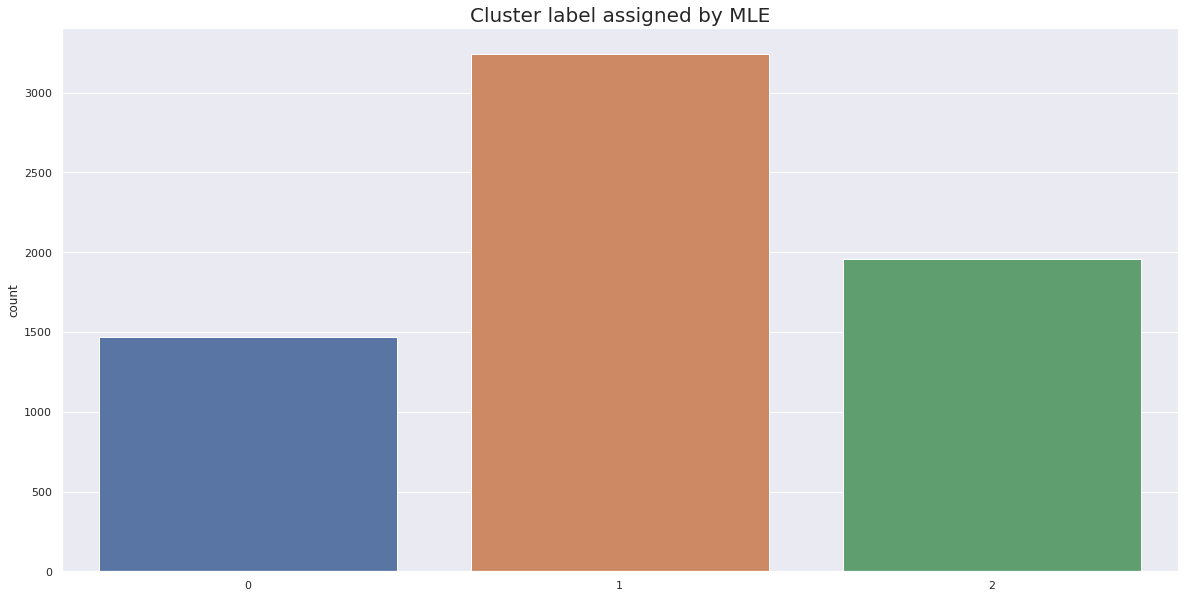

In [401]:
sns.set()
plt.figure(figsize=(20,10))
plt.title("Cluster label assigned by MLE", fontsize=20)
sns.countplot(labels)

In [405]:
labels.shape

(6669,)

In [411]:
valid_barcode_mask = np.isin(extract_barcodes(scRNA_counts_df), clustering_df.BARCODE)

In [410]:
clustering_df.LABEL.shape

(6126,)

In [412]:
ok_mle = labels[valid_barcode_mask] == 1
ok_seurat = np.isin(clustering_df.LABEL, [5,7,8,9])
pd.DataFrame(np.column_stack((ok_mle, ok_seurat)), 
             columns=["MLE", "seurat"])

,MLE,seurat
0,True,False
1,False,False
2,True,False
3,True,False
4,False,False
5,False,False
6,False,False
7,False,False
8,True,False
9,False,False


In [413]:
from sklearn.metrics import classification_report

print(classification_report(ok_seurat, ok_mle)) 

              precision    recall  f1-score   support

       False       0.94      0.52      0.67      5730
        True       0.07      0.52      0.12       396

    accuracy                           0.52      6126
   macro avg       0.51      0.52      0.40      6126
weighted avg       0.88      0.52      0.63      6126



In [414]:
tsne_tsv = "/icgc/dkfzlsdf/analysis/B260/projects/chromothripsis_medulloblastoma/single_cell_integration_dna_rna/scrna_vs_scdna/inputs/sample1_scRNA_Seurat_clusters.tsv"
tsne_df = pd.read_csv(tsne_tsv, sep='\t')
tsne_df.head()

,barcode,seurat_clusters,tSNE_1,tSNE_2
0,AAACCTGCACATCCAA-1,1,-12.448108,27.412456
1,AAACCTGCACTAGTAC-1,0,9.738823,11.845293
2,AAACCTGCATCATCCC-1,2,7.208576,-9.511222
3,AAACCTGGTAGCTCCG-1,1,-20.766361,18.106085
4,AAACCTGGTCTAAACC-1,2,5.619219,-12.530333


In [415]:
tsne_df.shape

(6126, 4)

In [96]:
len(barcode_list)

6669

In [95]:
pd.DataFrame(np.setdiff1d(barcode_list, tsne_df.barcode), 
             columns=["missing_barcode"]).to_csv("scRNA/missing_barcodes.tsv")

In [109]:
filtered_labels = labels[np.isin(barcode_list, tsne_df.barcode, assume_unique=True)]
tsne_df["mle_clusters"] = filtered_labels

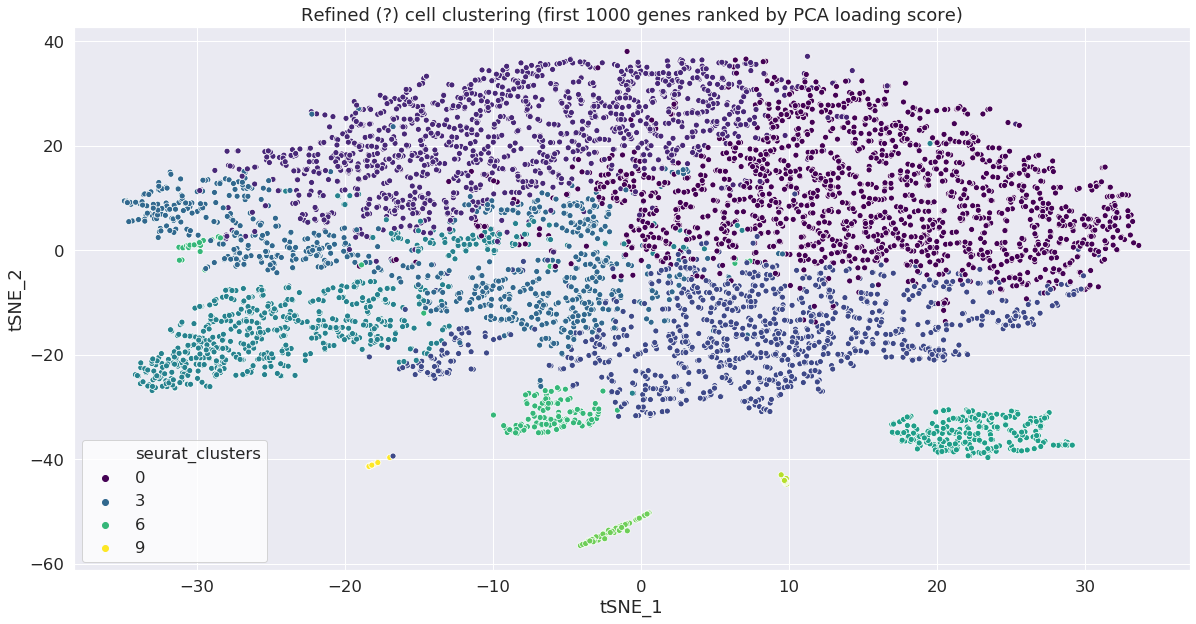

In [115]:
sns.set(font_scale=1.5);
plt.figure(figsize=(20,10))
plt.title("Refined (?) cell clustering (first 1000 genes ranked by PCA loading score)")
sns.scatterplot(x="tSNE_1", y="tSNE_2", hue="seurat_clusters", data=tsne_df, palette="viridis");
plt.legend().get_frame().set_facecolor("white");

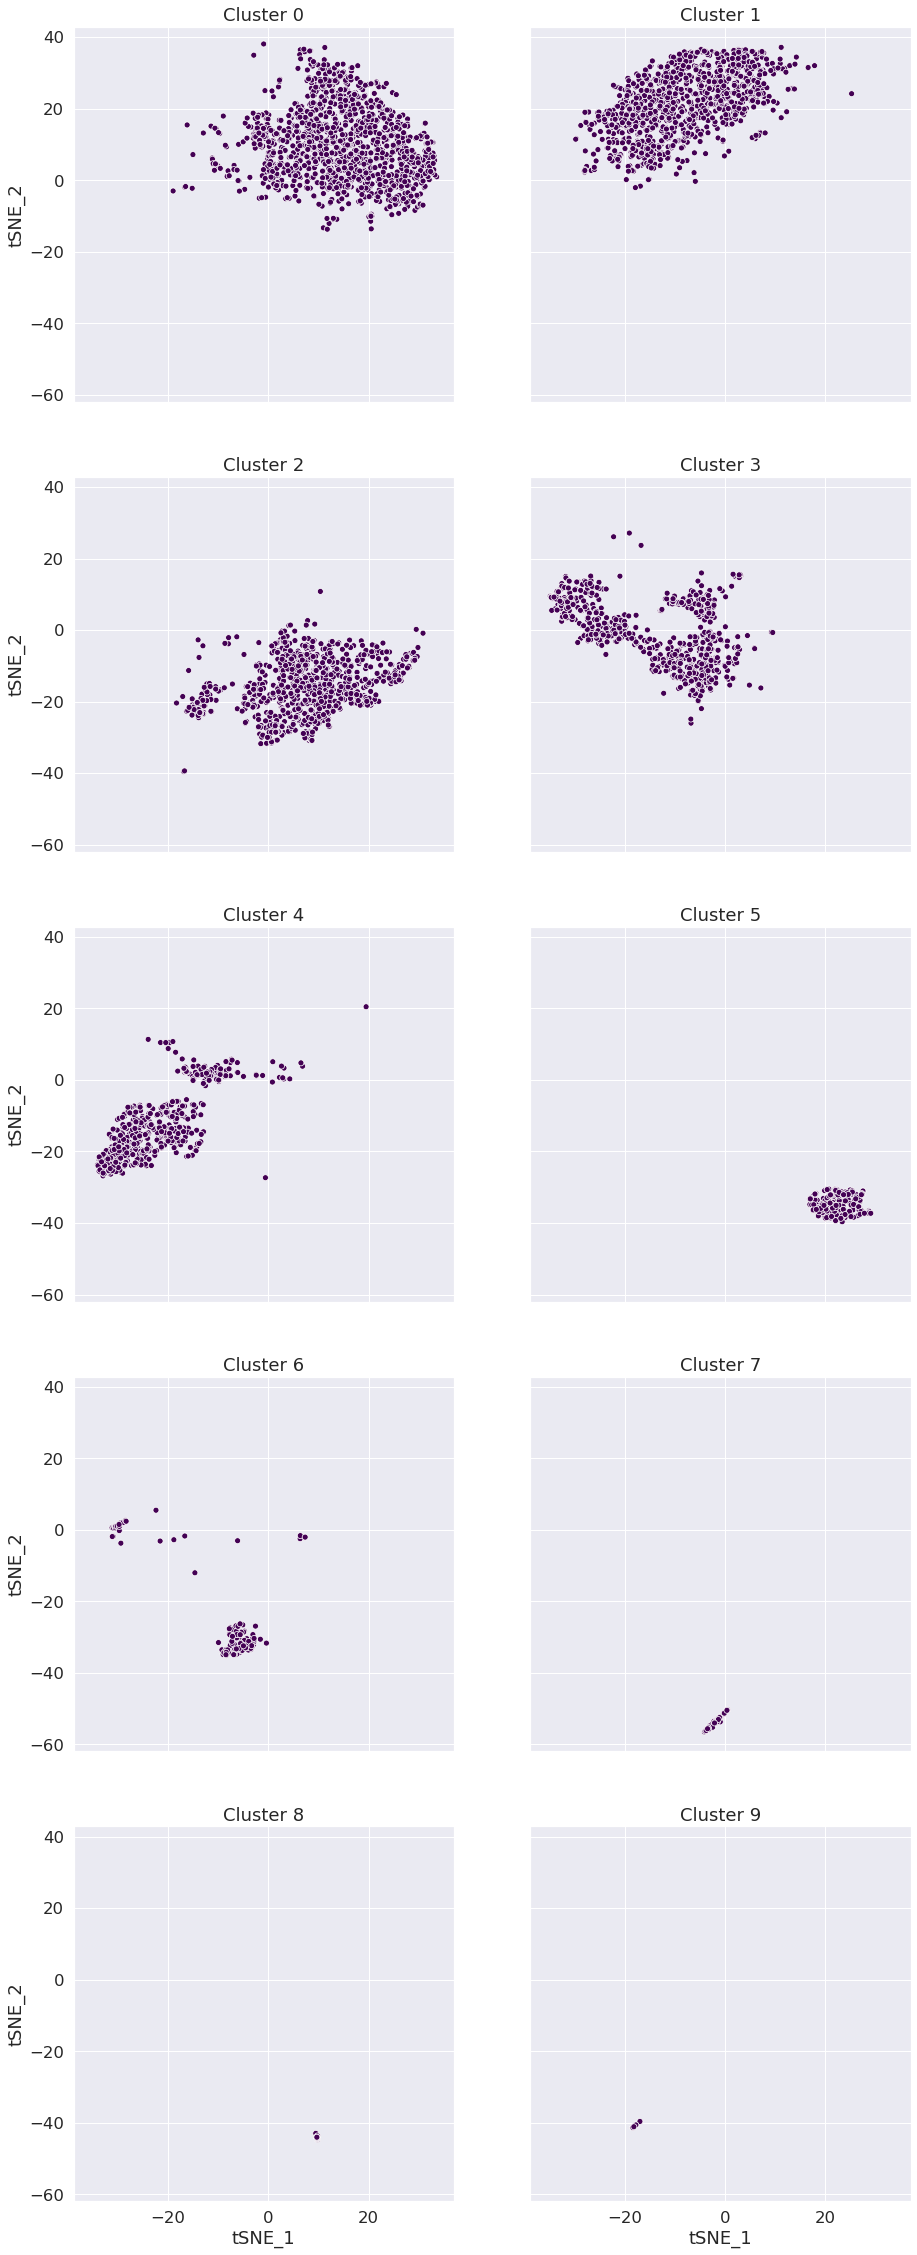

In [167]:
sns.set(font_scale=1.5);
fig, axes = plt.subplots(5, 2, figsize=(15,40), sharex=True, sharey=True)
for i in range(10):
    y, x = i//2, i%2
    sns.scatterplot(x="tSNE_1", y="tSNE_2", hue="seurat_clusters", 
                    data=tsne_df[tsne_df.seurat_clusters == i], 
                    palette="", ax=axes[y, x]);
    axes[y, x].set_title(f"Cluster {i}")
    axes[y, x].get_legend().remove()
#     axes[i//2, i%2].legend().get_frame().set_facecolor("white");

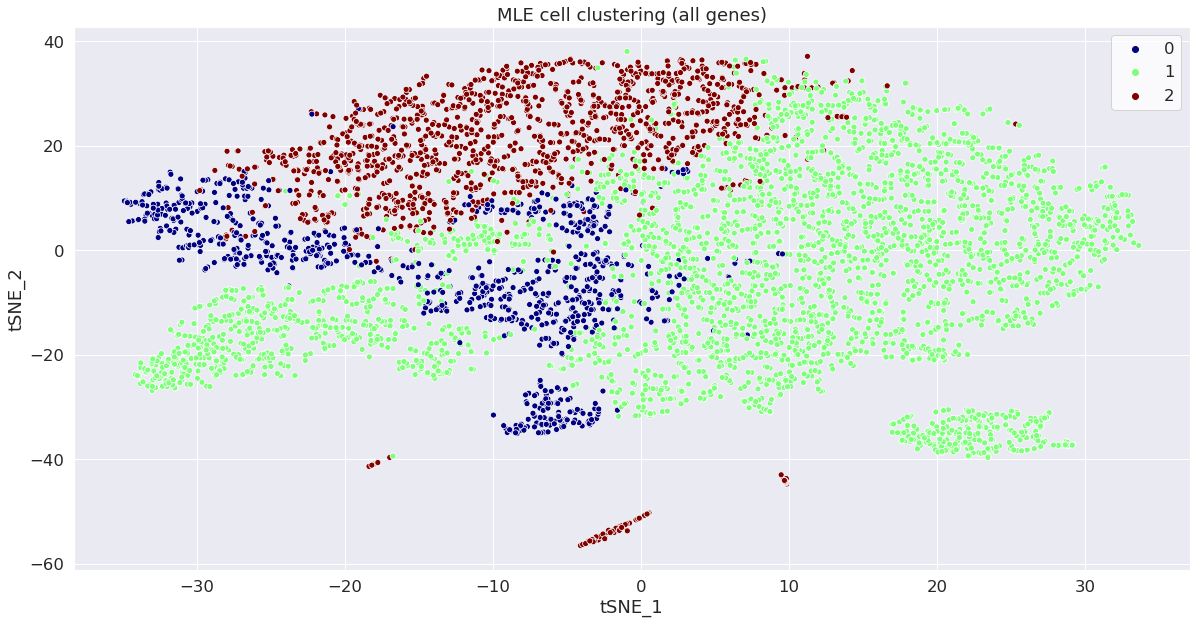

In [416]:
sns.set(font_scale=1.5);
plt.figure(figsize=(20,10))

true_labels = [labels[scl] for scl in tsne_df["seurat_clusters"]]
    
plt.title("MLE cell clustering (all genes)")

sns.scatterplot(x="tSNE_1", y="tSNE_2", hue=true_labels, data=tsne_df, palette="jet");
plt.legend().get_frame().set_facecolor("white");

In [80]:
labels_df = pd.DataFrame(np.column_stack((barcode_list, labels)), 
                         columns=["barcode", "cluster"])
labels_df.to_csv("scRNA/labels_26_07_top_1k_genes.tsv", sep='\t')